In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import zipfile, os

local_zip = '/content/drive/MyDrive/Pengembangan_ML/Rice_Image_Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

base_dir = '/content/Rice_Image_Dataset'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap',
                    validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
      base_dir,
      target_size=(100, 100),
      subset='training',
      class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
      base_dir,
      target_size=(100, 100),
      subset='validation',
      class_mode='categorical')

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 10, 10, 128)      

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy')>0.98) and (logs.get('val_accuracy')>0.98)):
      print("\nAkurasi dan Val Akurasi telah mencapai >98%!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=25,
      validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=2,
      callbacks=[callbacks])

Epoch 1/25
25/25 - 27s - loss: 1.0653 - accuracy: 0.5587 - val_loss: 0.9176 - val_accuracy: 0.5500 - 27s/epoch - 1s/step
Epoch 2/25
25/25 - 25s - loss: 0.4104 - accuracy: 0.8413 - val_loss: 0.4173 - val_accuracy: 0.8500 - 25s/epoch - 992ms/step
Epoch 3/25
25/25 - 32s - loss: 0.2563 - accuracy: 0.9100 - val_loss: 0.1804 - val_accuracy: 0.9187 - 32s/epoch - 1s/step
Epoch 4/25
25/25 - 25s - loss: 0.1896 - accuracy: 0.9287 - val_loss: 0.2549 - val_accuracy: 0.9250 - 25s/epoch - 1s/step
Epoch 5/25
25/25 - 26s - loss: 0.2297 - accuracy: 0.9250 - val_loss: 0.1835 - val_accuracy: 0.9438 - 26s/epoch - 1s/step
Epoch 6/25
25/25 - 25s - loss: 0.2237 - accuracy: 0.9262 - val_loss: 0.1555 - val_accuracy: 0.9250 - 25s/epoch - 1s/step
Epoch 7/25
25/25 - 24s - loss: 0.2095 - accuracy: 0.9250 - val_loss: 0.2545 - val_accuracy: 0.9000 - 24s/epoch - 967ms/step
Epoch 8/25
25/25 - 26s - loss: 0.1453 - accuracy: 0.9450 - val_loss: 0.2039 - val_accuracy: 0.9187 - 26s/epoch - 1s/step
Epoch 9/25
25/25 - 26s - l

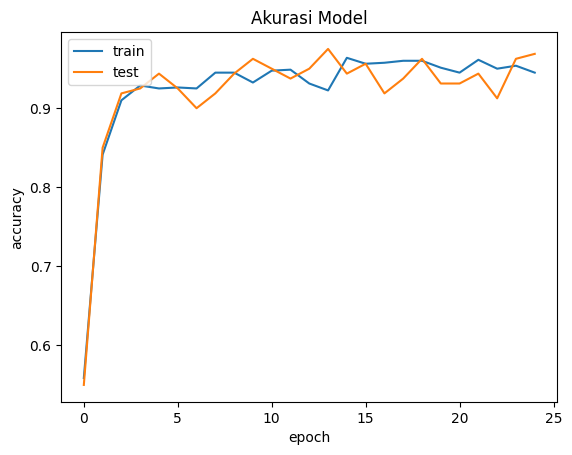

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

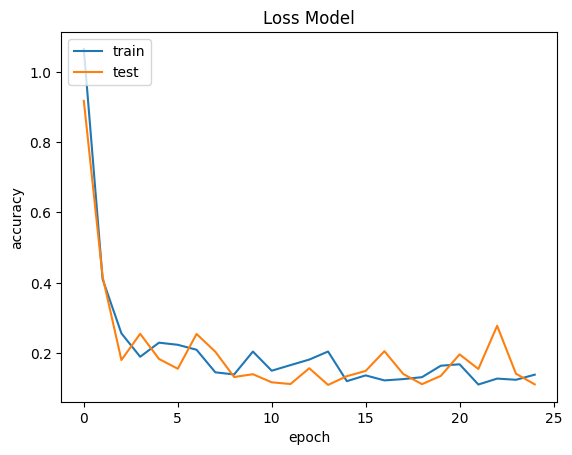

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import pathlib

# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('rice_image.tflite')
tflite_model_file.write_bytes(tflite_model)

6936608